In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

from scipy.stats import linregress, norm

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

import osmnx as ox
import networkx as nx

import pysal as ps
import libpysal as lps
import esda
import seaborn as sns

from tabulate import tabulate
from termcolor import colored

/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
style.use('seaborn-white')
input_output_folder = 'data'

# Parameters

In [3]:
local_crs = 'EPSG:28992'
sub_folder_1 = 'Amsterdam_14Apr2022'
sub_folder_2 = 'Rotterdam_14Apr2022'
sub_folder_3 = 'TheHague_14Apr2022'

In [4]:
trip_distances = [300, 500, 800]
trip_colors = ['#78c679', '#c2e699', '#ffffcc']

my_green = '#31a354'
my_pink = '#d01c8b'
my_grey = 'lightgrey'

seq_cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#f7fcb9'), (1, my_green)])
div_cmap = LinearSegmentedColormap.from_list('mycmap', [(0, my_pink), (0.5, my_grey), (1, my_green)])
diff_cmap = LinearSegmentedColormap.from_list('mycmap', [
    (0/7, '#8c510a'), 
    (1/7, '#bf812d'), 
    (2/7, '#dfc27d'),
    (3/7, '#f6e8c3'), 
    (4/7, '#c7eae5'), 
    (5/7, '#80cdc1'), 
    (6/7, '#35978f'), 
    (7/7, '#01665e'), 
])

betw_radius = 800

# Load data

In [5]:
gs_1 = gpd.read_file(os.path.join(input_output_folder, sub_folder_1, 'greenspace_accessibility.geojson'))
gs_1['city'] = sub_folder_1.split('_')[0]
gs_2 = gpd.read_file(os.path.join(input_output_folder, sub_folder_2, 'greenspace_accessibility.geojson'))
gs_2['city'] = sub_folder_2.split('_')[0]
gs_3 = gpd.read_file(os.path.join(input_output_folder, sub_folder_3, 'greenspace_accessibility.geojson'))
gs_3['city'] = sub_folder_3.split('_')[0]

In [6]:
gs_list = [gs_1, gs_2, gs_3]
greenspaces = gpd.GeoDataFrame(pd.concat(gs_list, ignore_index=True))
greenspaces.crs = local_crs

In [7]:
print('Amsterdam: ', len(gs_1))
print('Rotterdam: ', len(gs_2))
print('The Hague: ', len(gs_3))
print('In total:  ', len(greenspaces))

Amsterdam:  398
Rotterdam:  281
The Hague:  169
In total:   848


In [8]:
def set_types_geometries(df, cols):
    for col in cols:
        df[col] = df[col].apply(wkt.loads)
        gdf = gpd.GeoDataFrame(df, geometry=col)
        gdf.crs = local_crs

In [9]:
cols = []
for trip_dist in trip_distances:
    cols.append('geom_iso_'+str(trip_dist))

set_types_geometries(greenspaces, cols)

In [10]:
for col in greenspaces.columns:
    if not 'geom' in col:
        if not 'city' in col:
            greenspaces[col] = greenspaces[col].astype(float)

In [11]:
greenspaces = greenspaces.rename(columns={
    'pop_count_sum_300_rank': '0_base3_rank',
    'pop_count_sum_300': '0_base3',
    'pop_count_sum_500_rank': '0_base5_rank',
    'pop_count_sum_500': '0_base5',
    'pop_count_sum_800_rank': '0_base8_rank',
    'pop_count_sum_800': '0_base8',
    
    'cld_count_sum_300_rank': '1_res3C_rank',
    'cld_count_sum_300': '1_res3C',
    'adl_count_sum_300_rank': '2_res3A_rank',
    'adl_count_sum_300': '2_res3A',
    'cld_count_sum_500_rank': '3_res5C_rank',
    'cld_count_sum_500': '3_res5C',
    'adl_count_sum_500_rank': '4_res5A_rank',
    'adl_count_sum_500': '4_res5A',
    'cld_count_sum_800_rank': '5_res8C_rank',
    'cld_count_sum_800': '5_res8C',
    'adl_count_sum_800_rank': '6_res8A_rank',
    'adl_count_sum_800': '6_res8A',
    
    'educational_cld_count_300_rank': '7_edu3C_rank',
    'educational_cld_count_300': '7_edu3C',
    'educational_adl_count_300_rank': '8_edu3A_rank',
    'educational_adl_count_300': '8_edu3A',
    'educational_cld_count_500_rank': '9_edu5C_rank',
    'educational_cld_count_500': '9_edu5C',
    'educational_adl_count_500_rank': '10_edu5A_rank',
    'educational_adl_count_500': '10_edu5A',
    'educational_cld_count_800_rank': '11_edu8C_rank',
    'educational_cld_count_800': '11_edu8C',
    'educational_adl_count_800_rank': '12_edu8A_rank',
    'educational_adl_count_800': '12_edu8A',
    
    'betw_cld_800_dr12_entering_rank': '13_otms8C_rank',
    'betw_cld_800_dr12_entering': '13_otms8C',
    'betw_adl_800_dr12_entering_rank': '14_otms8A_rank',
    'betw_adl_800_dr12_entering': '14_otms8A',
    'betw_cld_800_dr12_wsum_rank': '15_otmw8C_rank',
    'betw_cld_800_dr12_wsum': '15_otmw8C',
    'betw_adl_800_dr12_wsum_rank': '16_otmw8A_rank',
    'betw_adl_800_dr12_wsum': '16_otmw8A',
    
    # 'compactness': 'compactness',
    # 'greenness_median': 'greenness',
    # 'sinuosity_median': 'sinuosity',
    # 'node_closeness_median': 'closeness',
})

# Plot accessibility measure outcomes

/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/Users/roosteeuwen/opt

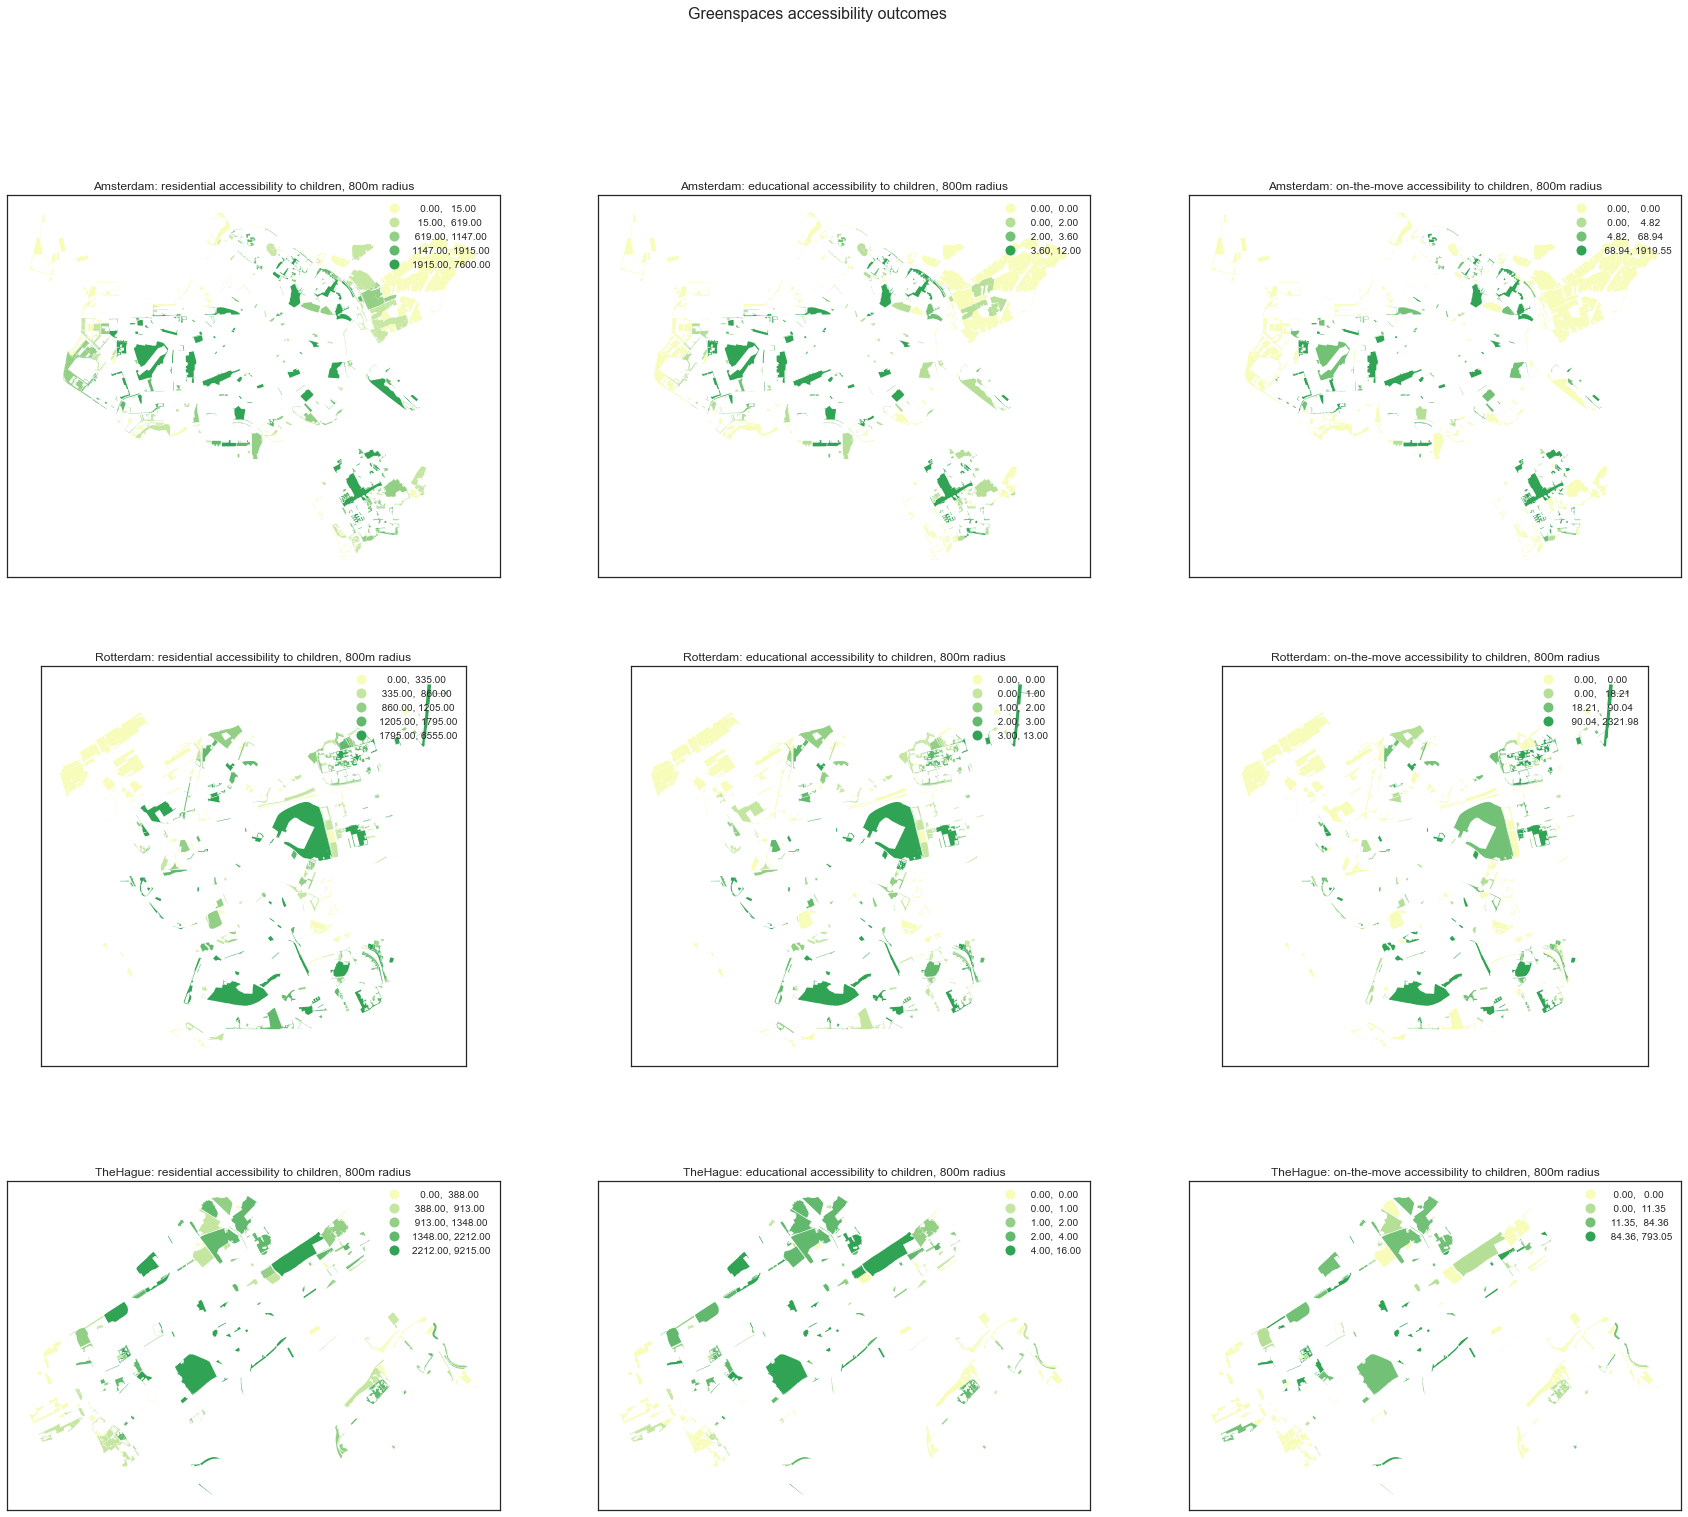

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,25))
fig.suptitle('Greenspaces accessibility outcomes', fontsize=16)

i = 0

for i in range(len(greenspaces.city.unique())):

    city = greenspaces.city.unique()[i]
    
    greenspaces[greenspaces['city']==city].plot(ax=axs[i,0], column='5_res8C', scheme='quantiles', cmap=seq_cmap, legend=True)
    axs[i,0].set_title('{}: residential accessibility to children, 800m radius'.format(city))
    
    greenspaces[greenspaces['city']==city].plot(ax=axs[i,1], column='11_edu8C', scheme='quantiles', cmap=seq_cmap, legend=True)
    axs[i,1].set_title('{}: educational accessibility to children, 800m radius'.format(city))
    
    greenspaces[greenspaces['city']==city].plot(ax=axs[i,2], column='13_otms8C'.format(str(betw_radius)), scheme='quantiles', cmap=seq_cmap, legend=True)
    axs[i,2].set_title('{}: on-the-move accessibility to children, 800m radius'.format(city))


for ax in axs:
    for a in ax:
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)

plt.show()

# Descriptive statistics

In [13]:
headers_descr = ['', '', 'N', 'mean', 'std.dev.', 'min', 'max']
rows_descr = []

acc_cols = ([col for col in greenspaces.columns if col.startswith('0_base') and not col.endswith('_rank')])
for i in range (1, 17):
    acc_cols.append([col for col in greenspaces.columns if col.startswith('{}_'.format(i)) and not col.endswith('_rank')][0])

for col in acc_cols:
    nr = col.split('_')[0]
    name = col.split('_')[1]

    row = [nr, name]
    
    row.append(len(greenspaces[greenspaces[col].notna()]))
    row.append(round(greenspaces[col].mean(), 1))
    row.append(round(greenspaces[col].std(), 1))
    row.append(round(greenspaces[col].min(), 0))
    row.append(round(greenspaces[col].max(), 0))
    # row.append(round(greenspaces[col].median(), 0))
    # row.append(round(scipy.stats.kstest(greenspaces[col], 'norm').pvalue, 3))

    rows_descr.append(row)

In [14]:
print(tabulate(rows_descr, headers=headers_descr))

              N     mean    std.dev.    min     max
--  ------  ---  -------  ----------  -----  ------
 0  base3   848   1524.5      1878.7      0   16605
 0  base5   848   3498.3      3872.3      0   31810
 0  base8   848   7763.3      7635.3      0   58110
 1  res3C   848    240.2       308.6      0    2240
 2  res3A   848    177.6       251.9      0    2055
 3  res5C   848    546         615.2      0    4630
 4  res5A   848    418.4       520.8      0    3730
 5  res8C   848   1203.6      1185.1      0    9215
 6  res8A   848    937.3      1030.8      0    6715
 7  edu3C   848      0.4         0.7      0       4
 8  edu3A   848      0.2         0.7      0       7
 9  edu5C   848      0.8         1.3      0      10
10  edu5A   848      0.5         1.2      0      11
11  edu8C   848      2           2.3      0      16
12  edu8A   848      1.1         2.1      0      16
13  otms8C  848     68.7       199.4      0    2322
14  otms8A  848     34.6       150.8      0    2287
15  otmw8C  

In [15]:
print(tabulate(rows_descr, headers=headers_descr, tablefmt='latex'))

\begin{tabular}{rlrrrrr}
\hline
    &        &   N &    mean &   std.dev. &   min &    max \\
\hline
  0 & base3  & 848 &  1524.5 &     1878.7 &     0 &  16605 \\
  0 & base5  & 848 &  3498.3 &     3872.3 &     0 &  31810 \\
  0 & base8  & 848 &  7763.3 &     7635.3 &     0 &  58110 \\
  1 & res3C  & 848 &   240.2 &      308.6 &     0 &   2240 \\
  2 & res3A  & 848 &   177.6 &      251.9 &     0 &   2055 \\
  3 & res5C  & 848 &   546   &      615.2 &     0 &   4630 \\
  4 & res5A  & 848 &   418.4 &      520.8 &     0 &   3730 \\
  5 & res8C  & 848 &  1203.6 &     1185.1 &     0 &   9215 \\
  6 & res8A  & 848 &   937.3 &     1030.8 &     0 &   6715 \\
  7 & edu3C  & 848 &     0.4 &        0.7 &     0 &      4 \\
  8 & edu3A  & 848 &     0.2 &        0.7 &     0 &      7 \\
  9 & edu5C  & 848 &     0.8 &        1.3 &     0 &     10 \\
 10 & edu5A  & 848 &     0.5 &        1.2 &     0 &     11 \\
 11 & edu8C  & 848 &     2   &        2.3 &     0 &     16 \\
 12 & edu8A  & 848 &     1.1 & 

# Correlations between accessibility measures

In [16]:
# Question: to what extent are the accessibility measures correlated with each other?

In [17]:
# spearman's (scipy)

headers_spea = ['', '']
rows_spea = []

for col_a in acc_cols:
    nr = col_a.split('_')[0]
    name = col_a.split('_')[1]

    row = [nr, name]
    
    for col_b in acc_cols:
        if col_a == col_b:
            row.append(1)
            break
        else:
            r, p = scipy.stats.spearmanr(greenspaces[col_a], greenspaces[col_b])
            r = round(r, 3)
            
            if p <= 0.05:
                r = str(r)+'*'
                if p <= 0.01:
                    r = r+'*'

            row.append(r)
    headers_spea.append(name)
    rows_spea.append(row)

In [18]:
print(tabulate(rows_spea, headers=headers_spea))

            base3    base5    base8    res3C    res3A    res5C    res5A    res8C    res8A    edu3C    edu3A    edu5C    edu5A    edu8C    edu8A    otms8C    otms8A    otmw8C      otmw8A
--  ------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------  --------  --------  --------  --------
 0  base3   1
 0  base5   0.962**  1
 0  base8   0.9**    0.961**  1
 1  res3C   0.962**  0.923**  0.858**  1
 2  res3A   0.958**  0.933**  0.877**  0.942**  1
 3  res5C   0.935**  0.962**  0.916**  0.957**  0.921**  1
 4  res5A   0.919**  0.961**  0.93**   0.895**  0.951**  0.936**  1
 5  res8C   0.88**   0.935**  0.962**  0.886**  0.866**  0.954**  0.913**  1
 6  res8A   0.854**  0.919**  0.963**  0.821**  0.879**  0.883**  0.949**  0.931**  1
 7  edu3C   0.547**  0.551**  0.53**   0.541**  0.539**  0.547**  0.534**  0.531**  0.509**  1
 8  edu3A   0.308**  0.333**  0.356**  0.285**  0.284**  0.306**  0.312**  0.324** 

In [19]:
print(tabulate(rows_spea, headers=headers_spea, tablefmt='latex'))

\begin{tabular}{rlllllllllllllllllllr}
\hline
    &        & base3   & base5   & base8   & res3C   & res3A   & res5C   & res5A   & res8C   & res8A   & edu3C   & edu3A   & edu5C   & edu5A   & edu8C   & edu8A   & otms8C   & otms8A   & otmw8C   &   otmw8A \\
\hline
  0 & base3  & 1       &         &         &         &         &         &         &         &         &         &         &         &         &         &         &          &          &          &          \\
  0 & base5  & 0.962** & 1       &         &         &         &         &         &         &         &         &         &         &         &         &         &          &          &          &          \\
  0 & base8  & 0.9**   & 0.961** & 1       &         &         &         &         &         &         &         &         &         &         &         &         &          &          &          &          \\
  1 & res3C  & 0.962** & 0.923** & 0.858** & 1       &         &         &         &         &         &   

# Differences in accessibility scores: res vs. edu vs. otm

In [20]:
# # normalise between 0 and max
# greenspaces['0_base8_norm'] = greenspaces['0_base8'] / greenspaces['0_base8'].max()

# greenspaces['5_res8C_norm'] = greenspaces['5_res8C'] / greenspaces['5_res8C'].max()
# greenspaces['6_res8A_norm'] = greenspaces['6_res8A'] / greenspaces['6_res8A'].max()
# greenspaces['11_edu8C_norm'] = greenspaces['11_edu8C'] / greenspaces['11_edu8C'].max()
# greenspaces['12_edu8A_norm'] = greenspaces['12_edu8A'] / greenspaces['12_edu8A'].max()
# greenspaces['13_otms8C_norm'] = greenspaces['13_otms8C'] / greenspaces['13_otms8C'].max()
# greenspaces['14_otms8A_norm'] = greenspaces['14_otms8A'] / greenspaces['14_otms8A'].max()

In [21]:
# greenspaces['diff_base8_res8C'] = greenspaces['0_base8_norm'] - greenspaces['5_res8C_norm']
# greenspaces['diff_base8_res8A'] = greenspaces['0_base8_norm'] - greenspaces['6_res8A_norm']
# greenspaces['diff_base8_edu8C'] = greenspaces['0_base8_norm'] - greenspaces['11_edu8C_norm']
# greenspaces['diff_base8_edu8A'] = greenspaces['0_base8_norm'] - greenspaces['12_edu8A_norm']
# greenspaces['diff_base8_otms8C'] = greenspaces['0_base8_norm'] - greenspaces['13_otms8C_norm']
# greenspaces['diff_base8_otms8A'] = greenspaces['0_base8_norm'] - greenspaces['14_otms8A_norm']

In [22]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# fig.suptitle('Greenspaces accessibility outcomes: differences with baseline approach', fontsize=16)

# xcols_set = [['diff_base8_res8C', 'diff_base8_res8A'], ['diff_base8_edu8C', 'diff_base8_edu8A'], ['diff_base8_otms8C', 'diff_base8_otms8A']]

# for i in range(len(xcols_set)):  
#     xcols = xcols_set[i]
#     for j in range(len(xcols)):
#         xcol = xcols[j]

#         if j==0:
#             group = 'children'
#         elif j==1:
#             group = 'adolescents'
#         if i==0:
#             approach = 'residential'
#         elif i==1:
#             approach = 'educational'
#         elif i==2:
#             approach = 'on-the-move'

#         axs[i,j].hlines(
#             y=greenspaces[greenspaces[xcol]>=0]['area']*10000, 
#             xmin=0, xmax=greenspaces[greenspaces[xcol]>=0][xcol],
#             color='#35978f')
#         axs[i,j].hlines(
#             y=greenspaces[greenspaces[xcol]<0]['area']*10000, 
#             xmin=0, xmax=greenspaces[greenspaces[xcol]<0][xcol],
#             color='#bf812d')
#         axs[i,j].set_title('Difference baseline and {} approach for {} (800m)'.format(approach, group))

# handles = [
#     mpatches.Patch(color='#35978f', label='Baseline overestimates'),
#     mpatches.Patch(color='#bf812d', label='Baseline underestimates')]

# for ax in axs:
#     for a in ax:
#         a.set_xlim(-1, 1)
#         a.set_ylabel('greenspace area (hectares)')
#         a.set_xlabel('under- or overestimate (normalised)')
#         a.legend(handles=handles, loc=2)

# plt.show()

In [23]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# fig.suptitle('Greenspaces accessibility outcomes: differences with baseline approach', fontsize=16)

# base_col = '0_base8_norm'
# my_cols_set = [['5_res8C_norm', '6_res8A_norm'], ['11_edu8C_norm', '12_edu8A_norm'], ['13_otms8C_norm', '14_otms8A_norm']]
# diff_cols_set = [['diff_base8_res8C', 'diff_base8_res8A'], ['diff_base8_edu8C', 'diff_base8_edu8A'], ['diff_base8_otms8C', 'diff_base8_otms8A']]

# for i in range(len(my_cols_set)):  
#     my_cols = my_cols_set[i]
#     for j in range(len(my_cols)):
#         my_col = my_cols[j]
#         diff_col = diff_cols_set[i][j]

#         if j==0:
#             group = 'children'
#         elif j==1:
#             group = 'adolescents'
#         if i==0:
#             approach = 'residential'
#         elif i==1:
#             approach = 'educational'
#         elif i==2:
#             approach = 'on-the-move'

#         axs[i,j].hlines(y=greenspaces['area']*10000, xmin=0, xmax=greenspaces[my_col], color=my_green, zorder=1)
#         axs[i,j].hlines(y=greenspaces['area']*10000, xmin=0, xmax=-greenspaces[base_col], color=my_grey, zorder=1)
#         axs[i,j].scatter(y=greenspaces['area']*10000, x=-greenspaces[diff_col], zorder=2)
#         axs[i,j].set_title('Difference baseline (grey) and {} approach for {} (800m) (green)'.format(approach, group))

# handles = [
#     mpatches.Patch(color=my_grey, label='Baseline'),
#     mpatches.Patch(color=my_green, label='Novel')]

# for ax in axs:
#     for a in ax:
#         a.set_xlim(-1, 1)
#         a.set_ylabel('greenspace area (hectares)')
#         a.set_xlabel('baseline (grey) vs. novel (green)')
#         a.legend(handles=handles, loc=2)

# plt.show()

In [24]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# fig.suptitle('Greenspaces accessibility outcomes: differences with baseline approach', fontsize=16)

# xcols_set = [['diff_base8_res8C', 'diff_base8_res8A'], ['diff_base8_edu8C', 'diff_base8_edu8A'], ['diff_base8_otms8C', 'diff_base8_otms8A']]

# for i in range(len(xcols_set)):  
#     xcols = xcols_set[i]
#     for j in range(len(xcols)):
#         xcol = xcols[j]

#         if j==0:
#             group = 'children'
#         elif j==1:
#             group = 'adolescents'
#         if i==0:
#             approach = 'residential'
#         elif i==1:
#             approach = 'educational'
#         elif i==2:
#             approach = 'on-the-move'

#         axs[i,j].hlines(
#             y=greenspaces[greenspaces[xcol]>=0]['0_base8'], 
#             xmin=0, xmax=greenspaces[greenspaces[xcol]>=0][xcol],
#             color='#35978f')
#         axs[i,j].hlines(
#             y=greenspaces[greenspaces[xcol]<0]['0_base8'], 
#             xmin=0, xmax=greenspaces[greenspaces[xcol]<0][xcol],
#             color='#bf812d')
#         axs[i,j].set_title('Difference baseline and {} approach for {} (800m)'.format(approach, group))

# handles = [
#     mpatches.Patch(color='#35978f', label='Baseline overestimates'),
#     mpatches.Patch(color='#bf812d', label='Baseline underestimates')]

# for ax in axs:
#     for a in ax:
#         a.set_xlim(-1, 1)
#         a.set_ylabel('baseline approach (nr of people)')
#         a.set_xlabel('under- or overestimate (normalised)')
#         a.legend(handles=handles, loc=2)

# plt.show()

In [25]:
# ams = greenspaces[greenspaces['city']=='Amsterdam']
# rtd = greenspaces[greenspaces['city']=='Rotterdam']
# hag = greenspaces[greenspaces['city']=='TheHague']

In [26]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# fig.suptitle('Greenspaces accessibility outcomes in Amsterdam: differences with baseline approach', fontsize=16)

# ams.plot(ax=axs[0,0], column='diff_base8_res8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[0,0].set_title('Difference baseline and residential approach for children (800m)')
# ams.plot(ax=axs[0,1], column='diff_base8_res8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[0,1].set_title('Difference baseline and residential approach for adolescents (800m)')

# ams.plot(ax=axs[1,0], column='diff_base8_edu8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[1,0].set_title('Difference baseline and educational approach for children (800m)')
# ams.plot(ax=axs[1,1], column='diff_base8_edu8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[1,1].set_title('Difference baseline and educational approach for adolescents (800m)')

# ams.plot(ax=axs[2,0], column='diff_base8_otms8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[2,0].set_title('Difference baseline and on-the-move approach for children (800m)')
# ams.plot(ax=axs[2,1], column='diff_base8_otms8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[2,1].set_title('Difference baseline and on-the-move approach for adolescents (800m)')


# handles = [
#     mpatches.Patch(color='#35978f', label='Baseline overestimates'),
#     mpatches.Patch(color='#c7eae5', label=''),
#     mpatches.Patch(color='#f6e8c3', label=''),
#     mpatches.Patch(color='#bf812d', label='Baseline underestimates')]

# for ax in axs:
#     for a in ax:
#         a.axes.get_xaxis().set_visible(False)
#         a.axes.get_yaxis().set_visible(False)
#         a.legend(handles=handles)

# plt.show()

In [27]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# fig.suptitle('Greenspaces accessibility outcomes in Rotterdam: differences with baseline approach', fontsize=16)

# rtd.plot(ax=axs[0,0], column='diff_base8_res8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[0,0].set_title('Difference baseline and residential approach for children (800m)')
# rtd.plot(ax=axs[0,1], column='diff_base8_res8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[0,1].set_title('Difference baseline and residential approach for adolescents (800m)')

# rtd.plot(ax=axs[1,0], column='diff_base8_edu8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[1,0].set_title('Difference baseline and educational approach for children (800m)')
# rtd.plot(ax=axs[1,1], column='diff_base8_edu8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[1,1].set_title('Difference baseline and educational approach for adolescents (800m)')

# rtd.plot(ax=axs[2,0], column='diff_base8_otms8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[2,0].set_title('Difference baseline and on-the-move approach for children (800m)')
# rtd.plot(ax=axs[2,1], column='diff_base8_otms8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[2,1].set_title('Difference baseline and on-the-move approach for adolescents (800m)')


# handles = [
#     mpatches.Patch(color='#35978f', label='Baseline overestimates'),
#     mpatches.Patch(color='#c7eae5', label=''),
#     mpatches.Patch(color='#f6e8c3', label=''),
#     mpatches.Patch(color='#bf812d', label='Baseline underestimates')]

# for ax in axs:
#     for a in ax:
#         a.axes.get_xaxis().set_visible(False)
#         a.axes.get_yaxis().set_visible(False)
#         a.legend(handles=handles)

# plt.show()

In [28]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# fig.suptitle('Greenspaces accessibility outcomes in The Hague: differences with baseline approach', fontsize=16)

# hag.plot(ax=axs[0,0], column='diff_base8_res8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[0,0].set_title('Difference baseline and residential approach for children (800m)')
# hag.plot(ax=axs[0,1], column='diff_base8_res8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[0,1].set_title('Difference baseline and residential approach for adolescents (800m)')

# hag.plot(ax=axs[1,0], column='diff_base8_edu8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[1,0].set_title('Difference baseline and educational approach for children (800m)')
# hag.plot(ax=axs[1,1], column='diff_base8_edu8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[1,1].set_title('Difference baseline and educational approach for adolescents (800m)')

# hag.plot(ax=axs[2,0], column='diff_base8_otms8C', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[2,0].set_title('Difference baseline and on-the-move approach for children (800m)')
# hag.plot(ax=axs[2,1], column='diff_base8_otms8A', cmap=diff_cmap, vmin=-1, vmax=1)
# axs[2,1].set_title('Difference baseline and on-the-move approach for adolescents (800m)')


# handles = [
#     mpatches.Patch(color='#35978f', label='Baseline overestimates'),
#     mpatches.Patch(color='#c7eae5', label=''),
#     mpatches.Patch(color='#f6e8c3', label=''),
#     mpatches.Patch(color='#bf812d', label='Baseline underestimates')]

# for ax in axs:
#     for a in ax:
#         a.axes.get_xaxis().set_visible(False)
#         a.axes.get_yaxis().set_visible(False)
#         a.legend(handles=handles)

# plt.show()

In [29]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,30))
# fig.suptitle('Greenspaces accessibility outcomes: differences in rankings between approaches', fontsize=16)

# for i in range(len(greenspaces.city.unique())):

#     city = greenspaces.city.unique()[i]
    
#     greenspaces[greenspaces['city']==city].plot(ax=axs[i,0], column='rank_res-edu', scheme='percentiles', cmap=diff_cmap, legend=True, vmin=-1)
#     axs[i,0].set_title('{}: residential vs. educational accessibility rank'.format(city))
    
#     greenspaces[greenspaces['city']==city].plot(ax=axs[i,1], column='rank_res-otm', scheme='percentiles', cmap=diff_cmap, legend=True, vmin=-1)
#     axs[i,1].set_title('{}: residential vs. on-the-move accessibility rank'.format(city))



# handles = [
#     mpatches.Patch(color=my_green, label='Residential underestimates'),
#     mpatches.Patch(color=my_grey, label='Similar estimation'),
#     mpatches.Patch(color=my_pink, label='Residential overestimates')]

# for ax in axs:
#     for a in ax:
#         a.axes.get_xaxis().set_visible(False)
#         a.axes.get_yaxis().set_visible(False)
# #         a.legend(handles=handles)

# plt.show()

# Scatter plots accessibility value and accessibility rank

In [30]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
# fig.suptitle('Greenspaces accessibility outcomes: value and rank', fontsize=16)

# greenspaces.plot.scatter(ax=axs[0,0], x='5_res8C_rank', y='5_res8C')
# greenspaces.plot.scatter(ax=axs[0,1], x='6_res8A_rank', y='6_res8A')

# greenspaces.plot.scatter(ax=axs[1,0], x='11_edu8C_rank', y='11_edu8C')
# greenspaces.plot.scatter(ax=axs[1,1], x='12_edu8A_rank', y='12_edu8A')

# greenspaces.plot.scatter(ax=axs[2,0], x='13_otms8C_rank', y='13_otms8C')
# greenspaces.plot.scatter(ax=axs[2,1], x='14_otms8A_rank', y='14_otms8A')

# plt.show

# Scatter plots behind accessibility correlations

In [31]:
marker_color = 'yellow'
hist_color = 'lightgrey'
scatter_cmap = plt.get_cmap('flare')

In [32]:
print(
    colors.rgb2hex(scatter_cmap(0.0)), # very weak
    colors.rgb2hex(scatter_cmap(0.15)), 
    colors.rgb2hex(scatter_cmap(0.3)), 
    colors.rgb2hex(scatter_cmap(0.45)), 
    colors.rgb2hex(scatter_cmap(0.6))) # very strong

#edb081 #e98b6a #e2655c #cc4663 #aa3a6e


In [33]:
fontsize_1 = 80
fontsize_2 = 60
fontsize_3 = 50
fontsize_4 = 30
scatter_size = 200
marker_size = 40
marker_width = 10

In [34]:
def my_scatter_plot(ax, xcol, ycol, color, scale=None, title=None, xlabel=None, ylabel=None):
    # scatter plot
    greenspaces.plot.scatter(ax=ax, x=xcol, y=ycol, color=color, s=scatter_size, alpha=0.1)
    
    # lines along medians
    x = np.linspace(0, greenspaces[xcol].max())
    min_x = greenspaces[col].min()
    med_x = greenspaces[xcol].median()
    mean_x = greenspaces[xcol].mean()
    max_x = greenspaces[xcol].max()
    y = np.linspace(0, greenspaces[ycol].max())
    med_y = greenspaces[ycol].median()
    mean_y = greenspaces[ycol].mean()
    max_y = greenspaces[ycol].max()
    a=1
    s='o'
    # ax.hlines(med_y, 0, max_x, color=marker_color, linestyle=':', alpha=a)
    # ax.vlines(med_x, 0, max_y, color=marker_color, linestyle=':', alpha=a)
    ax.plot(med_x, med_y, markeredgecolor=marker_color, markerfacecolor='none', markersize=marker_size, markeredgewidth=marker_width, marker=s, alpha=a)
    
    #exponential axes
    # if scale == 'log':
    #     ax.set_xscale(scale)
    #     ax.set_yscale(scale)
    
    # texts
    if title:
        ax.set_title(title, fontsize=fontsize_3, y=1.1)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize_4)
    else:
        ax.set_xlabel('')
        ax.get_xaxis().set_visible(False)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize_4)
        ax.yticks(fontsize=fontsize_4)
    else:
        ax.set_ylabel('')
        ax.get_yaxis().set_visible(False)
        
    # correlations
    r, p = scipy.stats.spearmanr(greenspaces[xcol], greenspaces[ycol])
    r = round(r, 3)
    if r == 1.000:
        r = str(int(r))
    else:
        r = '{:.3f}'.format(round(r, 3))
    corr_text = r"Spearman's $\rho$: {}".format(r)
    ax.text(min_x, 0.95*max_y, corr_text, fontsize=fontsize_4, style='italic')
    
    # ax.grid(True)

In [35]:
def my_histogram(ax, col, color, horizontal=False, scale=None, xlabel=None, ylabel=None):
    
    b=17
    
    if horizontal:
        greenspaces[col].hist(ax=ax, color=color, bins=b, orientation='horizontal')
    else:
        greenspaces[col].hist(ax=ax, color=color, bins=b)
    
    #exponential axes
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_yscale(scale)
    
    # texts
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize_4)
        ax.tick_params(axis='both', which='major', labelsize=fontsize_4)
    else:
        ax.set_xlabel('')
        ax.get_xaxis().set_visible(False)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize_4)
        ax.tick_params(axis='both', which='major', labelsize=fontsize_4)
    else:
        ax.set_ylabel('')
        ax.get_yaxis().set_visible(False)
        
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if horizontal:
        ax.spines['bottom'].set_visible(False)
    else:
        ax.spines['left'].set_visible(False)


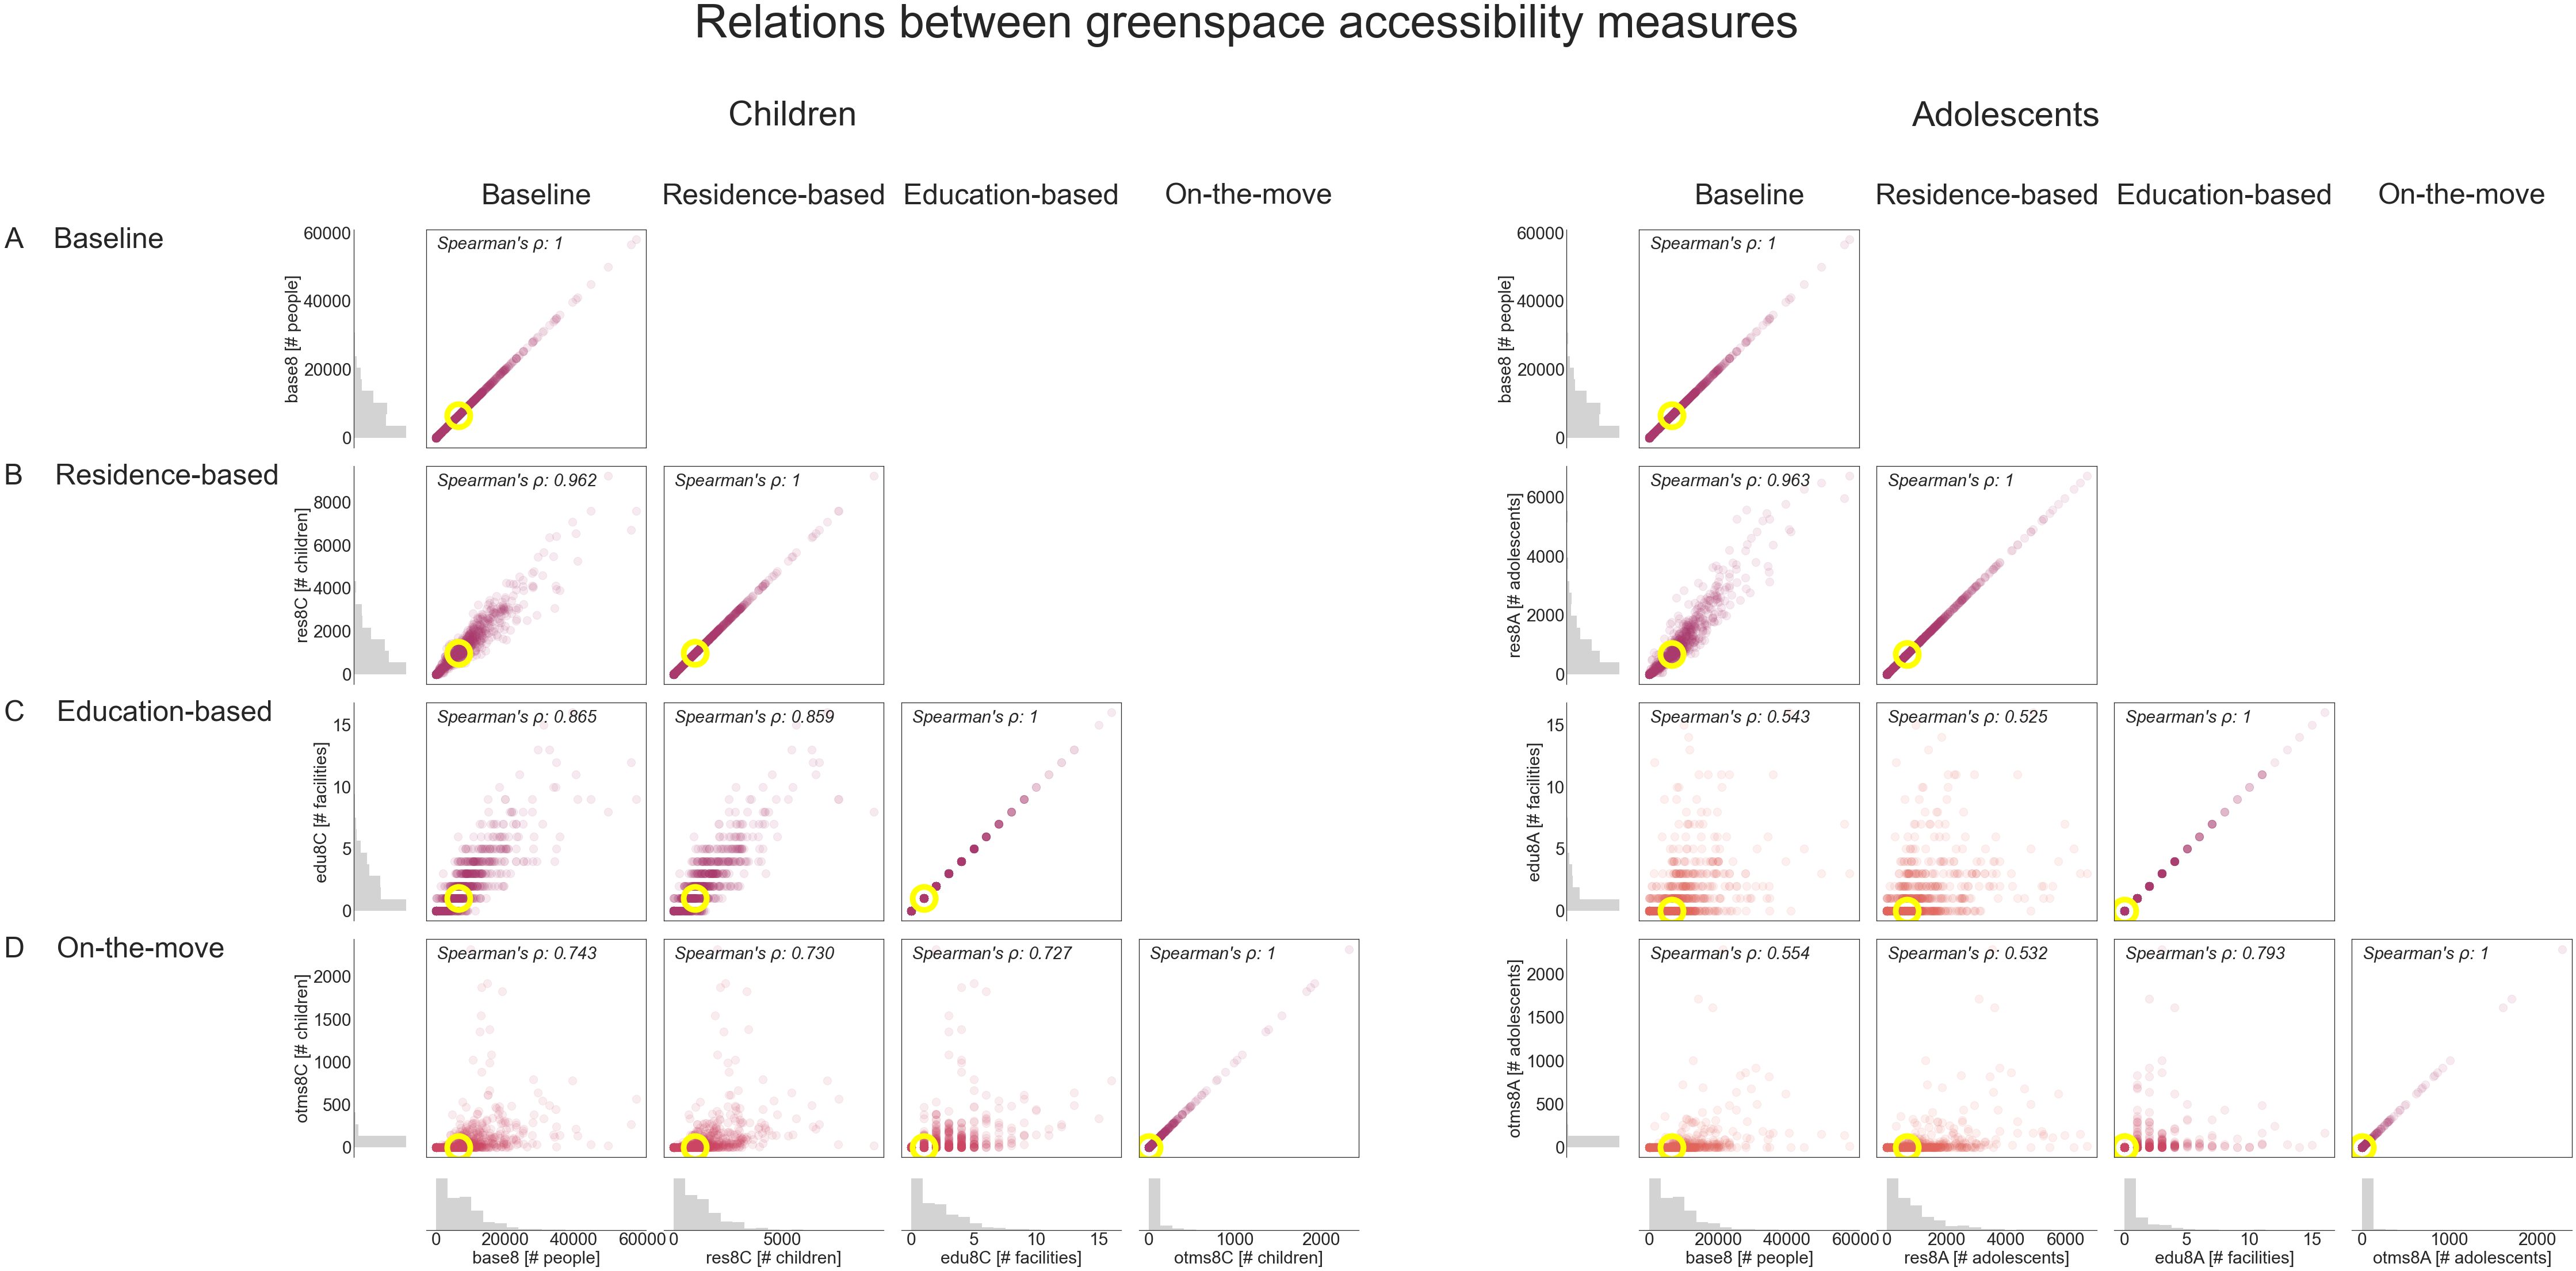

In [36]:
fig, axs = plt.subplots(figsize=(80,32))
fig.suptitle('Relations between greenspace accessibility measures', y=1.05, fontsize=fontsize_1)

# 2 blocks next to each other
gs_total = gridspec.GridSpec(
    1, 3, figure=fig, hspace=0.1, wspace=0.1,
    width_ratios=(1, 8, 8))


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# BLOCK 1 - TITLES
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
gs_titles = gridspec.GridSpecFromSubplotSpec(
    5, 1, subplot_spec=gs_total[0], hspace=0.1, wspace=0.1, 
    height_ratios=(4, 4, 4, 4, 1))

A_title = 'A    Baseline'
B_title = 'B    Residence-based'
C_title = 'C    Education-based'
D_title = 'D    On-the-move'

y=0.9
r=0
l='left'

title1 = fig.add_subplot(gs_titles[0])
title1.axis('off')
title1.set_title(A_title, fontsize=fontsize_3, y=y, rotation=r, loc=l)
title2 = fig.add_subplot(gs_titles[1])
title2.axis('off')
title2.set_title(B_title, fontsize=fontsize_3, y=y, rotation=r, loc=l)
title3 = fig.add_subplot(gs_titles[2])
title3.axis('off')
title3.set_title(C_title, fontsize=fontsize_3, y=y, rotation=r, loc=l)
title4 = fig.add_subplot(gs_titles[3])
title4.axis('off')
title4.set_title(D_title, fontsize=fontsize_3, y=y, rotation=r, loc=l)


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# BLOCK 2 - CHILDREN
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
A = '0_base8'
A_label = '{} [# people]'.format(A.split('_')[1])
B = '5_res8C'
B_label = '{} [# children]'.format(B.split('_')[1])
C = '11_edu8C'
C_label = '{} [# facilities]'.format(C.split('_')[1])
D = '13_otms8C'
D_label = '{} [# children]'.format(D.split('_')[1])

gs_cld = gridspec.GridSpecFromSubplotSpec(
    5, 6, subplot_spec=gs_total[1], hspace=0.1, wspace=0.1, 
    width_ratios=(2, 1, 4, 4, 4, 4), height_ratios=(4, 4, 4, 4, 1))

# block title
axtitle = fig.add_subplot(gs_cld[:])
axtitle.set_title('Children', fontsize=fontsize_2, y=1.1)
axtitle.axis('off')

# hist column
my_histogram(fig.add_subplot(gs_cld[0,1]), A, color=hist_color, horizontal=True, ylabel=A_label)
my_histogram(fig.add_subplot(gs_cld[1,1]), B, color=hist_color, horizontal=True, ylabel=B_label)
my_histogram(fig.add_subplot(gs_cld[2,1]), C, color=hist_color, horizontal=True, ylabel=C_label)
my_histogram(fig.add_subplot(gs_cld[3,1]), D, color=hist_color, horizontal=True, ylabel=D_label)

# first column
my_scatter_plot(fig.add_subplot(gs_cld[0,2]), A, A, color=scatter_cmap(0.6), title=A_title.split(' ')[-1])
my_scatter_plot(fig.add_subplot(gs_cld[1,2]), A, B, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_cld[2,2]), A, C, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_cld[3,2]), A, D, color=scatter_cmap(0.45))
my_histogram(fig.add_subplot(gs_cld[4,2]), A, color=hist_color, xlabel=A_label)

# second column
head2 = fig.add_subplot(gs_cld[0,3])
head2.axis('off')
head2.set_title(B_title.split(' ')[-1], fontsize=fontsize_3, y=1.1)
my_scatter_plot(fig.add_subplot(gs_cld[1,3]), B, B, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_cld[2,3]), B, C, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_cld[3,3]), B, D, color=scatter_cmap(0.45))
my_histogram(fig.add_subplot(gs_cld[4,3]), B, color=hist_color, xlabel=B_label)

# third column
head3 = fig.add_subplot(gs_cld[0,4])
head3.axis('off')
head3.set_title(C_title.split(' ')[-1], fontsize=fontsize_3, y=1.1)
fig.add_subplot(gs_cld[1,4]).axis('off')
my_scatter_plot(fig.add_subplot(gs_cld[2,4]), C, C, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_cld[3,4]), C, D, color=scatter_cmap(0.45))
my_histogram(fig.add_subplot(gs_cld[4,4]), C, color=hist_color, xlabel=C_label)

# fourth column
head4 = fig.add_subplot(gs_cld[0,5])
head4.axis('off')
head4.set_title(D_title.split(' ')[-1], fontsize=fontsize_3, y=1.1)
fig.add_subplot(gs_cld[1,5]).axis('off')
fig.add_subplot(gs_cld[2,5]).axis('off')
my_scatter_plot(fig.add_subplot(gs_cld[3,5]), D, D, color=scatter_cmap(0.6))
my_histogram(fig.add_subplot(gs_cld[4,5]), D, color=hist_color, xlabel=D_label)


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# BLOCK 3 - ADOLESCENTS
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
A = '0_base8'
A_label = '{} [# people]'.format(A.split('_')[1])
B = '6_res8A'
B_label = '{} [# adolescents]'.format(B.split('_')[1])
C = '12_edu8A'
C_label = '{} [# facilities]'.format(C.split('_')[1])
D = '14_otms8A'
D_label = '{} [# adolescents]'.format(D.split('_')[1])

gs_adl = gridspec.GridSpecFromSubplotSpec(
    5, 6, subplot_spec=gs_total[2], hspace=0.1, wspace=0.1, 
    width_ratios=(2, 1, 4, 4, 4, 4), height_ratios=(4, 4, 4, 4, 1))

# block title
axtitle = fig.add_subplot(gs_adl[:])
axtitle.set_title('Adolescents', fontsize=fontsize_2, y=1.1)
axtitle.axis('off')

# hist column
my_histogram(fig.add_subplot(gs_adl[0,1]), A, color=hist_color, horizontal=True, ylabel=A_label)
my_histogram(fig.add_subplot(gs_adl[1,1]), B, color=hist_color, horizontal=True, ylabel=B_label)
my_histogram(fig.add_subplot(gs_adl[2,1]), C, color=hist_color, horizontal=True, ylabel=C_label)
my_histogram(fig.add_subplot(gs_adl[3,1]), D, color=hist_color, horizontal=True, ylabel=D_label)

# first column
my_scatter_plot(fig.add_subplot(gs_adl[0,2]), A, A, color=scatter_cmap(0.6), title=A_title.split(' ')[-1])
my_scatter_plot(fig.add_subplot(gs_adl[1,2]), A, B, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_adl[2,2]), A, C, color=scatter_cmap(0.3))
my_scatter_plot(fig.add_subplot(gs_adl[3,2]), A, D, color=scatter_cmap(0.3))
my_histogram(fig.add_subplot(gs_adl[4,2]), A, color=hist_color, xlabel=A_label)

# second column
head2 = fig.add_subplot(gs_adl[0,3])
head2.axis('off')
head2.set_title(B_title.split(' ')[-1], fontsize=fontsize_3, y=1.1)
my_scatter_plot(fig.add_subplot(gs_adl[1,3]), B, B, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_adl[2,3]), B, C, color=scatter_cmap(0.3))
my_scatter_plot(fig.add_subplot(gs_adl[3,3]), B, D, color=scatter_cmap(0.3))
my_histogram(fig.add_subplot(gs_adl[4,3]), B, color=hist_color, xlabel=B_label)

# third column
head3 = fig.add_subplot(gs_adl[0,4])
head3.axis('off')
head3.set_title(C_title.split(' ')[-1], fontsize=fontsize_3, y=1.1)
fig.add_subplot(gs_adl[1,4]).axis('off')
my_scatter_plot(fig.add_subplot(gs_adl[2,4]), C, C, color=scatter_cmap(0.6))
my_scatter_plot(fig.add_subplot(gs_adl[3,4]), C, D, color=scatter_cmap(0.45))
my_histogram(fig.add_subplot(gs_adl[4,4]), C, color=hist_color, xlabel=C_label)

# fourth column
head4 = fig.add_subplot(gs_adl[0,5])
head4.axis('off')
head4.set_title(D_title.split(' ')[-1], fontsize=fontsize_3, y=1.1)
fig.add_subplot(gs_adl[1,5]).axis('off')
fig.add_subplot(gs_adl[2,5]).axis('off')
my_scatter_plot(fig.add_subplot(gs_adl[3,5]), D, D, color=scatter_cmap(0.6))
my_histogram(fig.add_subplot(gs_adl[4,5]), D, color=hist_color, xlabel=D_label)



axs.axis('off')

plt.show()